# Author

Daniel Soto

# Introduction

This notebook will create cost duration curves from the measured apparent power on the Sentani microgrids.

This extends the work in the 2017-08-03 notebook.

# Method

Transform the kVA load time series to a fuel rate time series using the fuel rate fit from the generator fuel curves.
Then display the 

- generator fuel curves
- load duration curves in kVA and percent of rated load
- fuel-use duration curve

The duration curves are created by getting all non-zero finite values, and sorting in decending order.
The x-axis is normalized for the fraction of the observed running of each microgrid.

# Results

One of the microgrids, despite running at about 30% of the rated load, still has a reasonable rate of fuel per kVA-hour.
One of the grids has mean fuel rate over 50% higher than this.
The least efficient grid has a mean fuel rate over 3 times the best rate.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa

In [3]:
def get_generator_fuel_rate_fit(rfd):
    # returns linear fit of fuel rate to kVA load
    rated_load_kVA = rfd['datasheet_rated_load_kVA']
    load = np.array(rfd['load_fraction']) * rated_load_kVA
    return np.polyfit(load,
                      rfd['liters_per_hour'],
                      1)

Generator Fuel Rate Curves


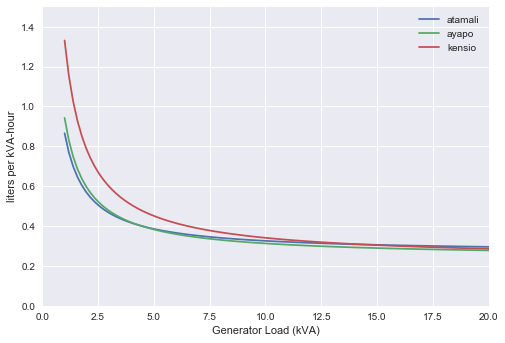

In [4]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    fit = get_generator_fuel_rate_fit(rfd)
    load = np.linspace(0.05, 1.0, 100) * 20.0
    hours = 1.0
    load_hours = load * hours
    fuel_rate = np.polyval(fit, load)
    fuel = fuel_rate * hours
    heat_rate = fuel / load_hours
    plt.plot(load, heat_rate, label=vname)

print('Generator Fuel Rate Curves')
plt.xlim((0, 20))
plt.ylim((0, 1.5))
plt.legend()
plt.xlabel('Generator Load (kVA)')
plt.ylabel('liters per kVA-hour')
plt.show()

Load Duration Curves (kVA)


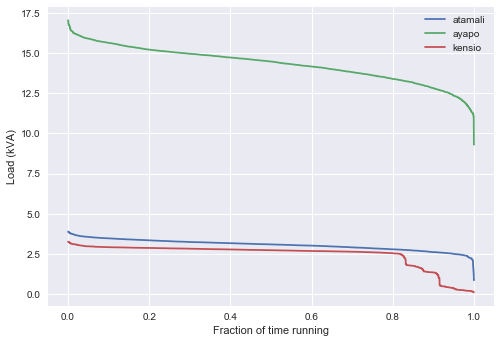

In [5]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    kVA.sort()
    kVA = kVA[::-1]
    index = np.linspace(0, 1, len(kVA))
    plt.plot(index, kVA, label=vname)

print('Load Duration Curves (kVA)')
plt.legend()
plt.xlabel('Fraction of time running')
plt.ylabel('Load (kVA)')
plt.show()

Load Duration Curves (percent rated load)


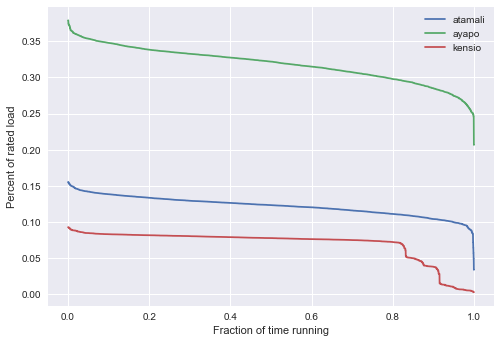

In [6]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA / rfd['datasheet_rated_load_kVA']
    kVA = kVA[kVA != 0.0]
    kVA.sort()
    kVA = kVA[::-1]
    index = np.linspace(0, 1, len(kVA))
    plt.plot(index, kVA, label=vname)

print('Load Duration Curves (percent rated load)')
plt.legend()
plt.xlabel('Fraction of time running')
plt.ylabel('Percent of rated load')
plt.show()

Fuel Rate Duration curves


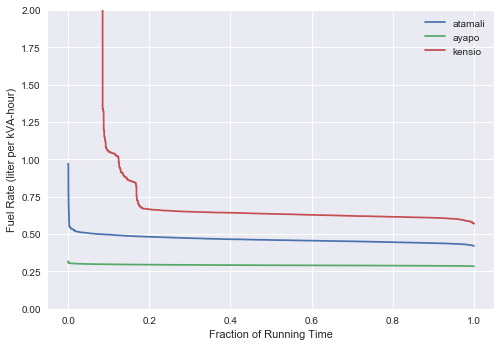

In [7]:
fig, ax = plt.subplots()
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    fit = get_generator_fuel_rate_fit(rfd)
    # create fuel rate time series from kVA data
    fuel_rate = np.polyval(fit, kVA)
    fuel_per_kVA_hour = fuel_rate / kVA
    fuel_per_kVA_hour.sort()
    fuel_per_kVA_hour = fuel_per_kVA_hour[::-1]
    index = np.linspace(0, 1, len(fuel_per_kVA_hour))
    plt.plot(index, fuel_per_kVA_hour, label=vname)

print('Fuel Rate Duration curves')
plt.legend()
plt.xlabel('Fraction of Running Time')
plt.ylabel('Fuel Rate (liter per kVA-hour)')
plt.ylim((0,2))
plt.show()

In [8]:
data = []
for rfd in wpa.raw_file_data[2:]:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    kVA = energy_data['kVA sliding window Demand'].dropna().values
    kVA = kVA[kVA != 0.0]
    fit = get_generator_fuel_rate_fit(rfd)
    fuel_rate = np.polyval(fit, kVA)
    fuel_per_kVA_hour = fuel_rate / kVA
    data.append({'village' : vname,
                 'max fuel rate' : fuel_rate.max(),
                 'min fuel rate' : fuel_rate.min(),
                 'max fuel per kVA' : fuel_per_kVA_hour.max(),
                 'min fuel per kVA' : fuel_per_kVA_hour.min(),
                 'mean fuel per kVA' : fuel_per_kVA_hour.mean(),
                 'max kVA' : kVA.max(),
                 'min kVA' : kVA.min(),
                 'p0' : fit[0],
                 'p1' : fit[1],
                 'capacity' : rfd['genset_rating_kVA']})
pd.DataFrame(data)

,capacity,max fuel per kVA,max fuel rate,max kVA,mean fuel per kVA,min fuel per kVA,min fuel rate,min kVA,p0,p1,village
0,25.0,0.969825,1.631590,3.884,0.464457,0.420080,0.826291,0.852,0.265600,0.6,atamali
1,40.0,0.317952,4.835283,17.041,0.291828,0.283744,2.956315,9.298,0.242667,0.7,ayapo
2,35.0,10.230857,1.850978,3.253,0.972835,0.569007,1.125394,0.110,0.230857,1.1,kensio


In [9]:
.46/.29

1.5862068965517244

In [10]:
.97/.29

3.344827586206897